# Extract and work with stimulated cells

In [1]:
# Imports:
%load_ext autoreload
%autoreload 2

import json
import numpy as np
import math
import psycopg2
import numpy as np
import pandas as pd
from datetime import date
from tqdm import tqdm_notebook

# Plotting:
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib as mpl
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set()

# External functions from subfolder /database_helpers. 
# as soon as you change something in there and press save, it will auto reload on next execution.
from database_helpers.psql_start import *
from database_helpers.create_tables import *
from database_helpers.write2tables import *
from postgres_analysis_helpers.general import *
from postgres_analysis_helpers.get_data import *
from postgres_analysis_helpers.circstat_functions import *
# register pickle type to retrieve binary data from database
psycopg2.extensions.register_type(psycopg2.extensions.new_type(psycopg2.BINARY.values, 'BINARY-PICKLE', cast_pickle))

Loaded analysis helpers: General
Loaded postgres_analysis_helpers -> general
Loaded postgres_analysis_helpers -> get_data
Loaded postgres_analysis_helpers -> circstat_functions


In [2]:
# Database connection check
db_status = test_connect()
if db_status == False:
    print('Grrr... no database connection could be established.')
else:
    print('Woot! Database connection is established!')

Connecting to the PostgreSQL database...
Woot! Database connection is established!


### Connect to the database 

In [29]:
stimulus_stats = pd.DataFrame() # create empty dataframe or feed in a base dataframe from before! 
psql = psql_neuroballs(stimulus_stats) # initialize retrieval

78 animals across 5 experimenters found.
Total # of sessions: 8624 (unique clusters: 15356)


**First retrieve all stimulus stats**. That means that only cells for which stimulus sessions were actually run are included in this retrieval step. No baseline sessions are present - only the laser sessions.
This is because the `stimulus_tb` table only contains laser stimulus session information - nothing else! 

In [4]:
dict_ = {'stimulus_tb': ''}
animals_ = ['74470','74471','74933','74935','74472','74473','74956','73358']

stimulus_stats = psql.retrieve_data(dict_,animals_)

8856 entries retrieved.


### Set parameters

In [5]:
# Set parameters:
# excitation:
salt_i_thresh = 0.09
salt_p_thresh = 0.05
min_number_sessions = 2 # min number of session for which criteria above have to be fullfilled
pearson_r_thresh = 0.99 # waveform similarity cutoff

# inhibition:
inhib_p_thresh = 0.001

# ISI contamination (%)
isi_contam_thresh = 1


### Filter for stimulated cells 

The way to do it is as follows: 
- Filter the stimulus stats for **SALT p** and **SALT i** according to the user defined thresholds (see parameters above)
- Sort dataframe by **SALT i**
- Count sessions and filter for **session count** (number of sessions that meet the above criteria) - this gets rid of all duplicate sessions
- Get waveforms (on the same dataframe - meaning the waveforms of the laser sessions with highest SALT i) 
- Drop **NaNs in waveforms** column. This is legit because ultra low responsive / firing cells that cross the treshold by chance would have to be filtered out anyway. If a NaN appears in this column, the analysis did not run over this cell in this session because there were less than 50 spikes recorded. 
- Then drop the "session_name" column, to get rid of the laser session label and then run over the database with filter for "laser" in session_name to only retrieve baseline sessions (can be expanded with for example "object" to exclude other open field sessions as well). In that step retrieve the baseline waveforms and ISI contamination (%).
- Filter for **ISI contamination**
- Filter for **Waveform correlation** (median correlation of all waveform channel pairs > threshold)

In [6]:
# Filter for SALT p and SALT i 
excited_cells = stimulus_stats[(stimulus_stats.salt_i > salt_i_thresh) & (stimulus_stats.salt_p < salt_p_thresh)].copy()
excited_cells.sort_values(by='salt_i',ascending=False,inplace=True)

In [7]:
excited_cells.head(3)

,session_name,n_drive_user,cluster_no,session_ts,animal_id,tetrode_no,analysis_ts,filename,analysis_window,salt_window,...,ex_latency_var,ex_latency_reliabil,stats_p_inhib_10,stats_p_inhib_20,stats_p_inhib_30,stats_p_inhib_40,inhibited,inhib_lowest_p,inhib_lowest_p_interval,change_point_ms
1302,10092017laserSess1(5mw),davidcr,23,2017-09-10 12:41:58,74472,6,2017-09-10 16:23:58.065,N:/davidcr/74472/10092017/KLUSTA/1.kwik,200.0,10.0,...,1.287718,0.934066,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN
82,16082017laserSess1(80mw),davidcr,5,2017-08-16 11:34:38,73358,5,2017-08-24 19:53:12.204,N:/davidcr/73358/16082017/KLUSTA/0.kwik,200.0,10.0,...,0.531419,0.868132,0.111697,0.144432,0.155952,0.161808,False,0.111697,10.0,NaN
1304,10092017laserSess1(10mw),davidcr,23,2017-09-10 12:41:58,74472,6,2017-09-10 16:23:58.065,N:/davidcr/74472/10092017/KLUSTA/1.kwik,200.0,10.0,...,1.027340,0.895604,NaN,0.001375,0.001196,0.000831,False,NaN,NaN,NaN


### Count sessions and filter for session number

In [8]:
# Group by and count - and also drop duplicates with sort
drop_subgroup = ['animal_id','n_drive_user','session_ts','cluster_no','tetrode_no']
no_sessions_excited = excited_cells.groupby(drop_subgroup).size().reset_index().copy()
excited_cells_sessions = excited_cells.drop_duplicates(drop_subgroup).sort_values(by=drop_subgroup).reset_index().copy()

# Quick sanity check (both have to be true)
if ((no_sessions_excited.animal_id.values == excited_cells_sessions.animal_id.values).all() != True) or ((no_sessions_excited.cluster_no.values == excited_cells_sessions.cluster_no.values).all() != True): 
    print('DATAFRAMES DO NOT MATCH!'); sys.exit()

In [9]:
excited_cells_sessions['no_sessions'] = no_sessions_excited.iloc[:,-1].values
len_before_no_session = len(excited_cells_sessions)
#overwrite original df
excited_cells = excited_cells_sessions[excited_cells_sessions.no_sessions >= min_number_sessions]

In [10]:
excited_cells.head(3)

,index,session_name,n_drive_user,cluster_no,session_ts,animal_id,tetrode_no,analysis_ts,filename,analysis_window,...,ex_latency_reliabil,stats_p_inhib_10,stats_p_inhib_20,stats_p_inhib_30,stats_p_inhib_40,inhibited,inhib_lowest_p,inhib_lowest_p_interval,change_point_ms,no_sessions
0,95,16082017laserSess1(40mw),davidcr,2,2017-08-16 11:34:38,73358,6,2017-08-24 19:53:24.638,N:/davidcr/73358/16082017/KLUSTA/1.kwik,200.0,...,0.149171,0.007625,0.021757,0.006127,0.139163,False,0.006127,30.0,NaN,2
1,100,16082017laserSess1(80mw),davidcr,3,2017-08-16 11:34:38,73358,7,2017-08-24 19:53:54.807,N:/davidcr/73358/16082017/KLUSTA/2.kwik,200.0,...,0.631868,0.234266,0.275281,0.289207,0.605833,False,0.234266,10.0,NaN,2
2,82,16082017laserSess1(80mw),davidcr,5,2017-08-16 11:34:38,73358,5,2017-08-24 19:53:12.204,N:/davidcr/73358/16082017/KLUSTA/0.kwik,200.0,...,0.868132,0.111697,0.144432,0.155952,0.161808,False,0.111697,10.0,NaN,3


### Get waveforms (laser sessions)

In [11]:
psql = psql_neuroballs(excited_cells) # initialize retrieval
dict_ = {'waveforms_tb':'mean_wf'}
excited_cells = psql.retrieve_data(dict_)

Length of input dataframe: 120
Dataframe not empty


HBox(children=(IntProgress(value=0, description='Mining tables: ', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, description='waveforms_tb: ', max=120), HTML(value='')))

Success. NaNs: 57



### Drop all NaNs in waveforms - this is valid if we want to include sessions only if there were > 50 spikes

In [12]:
len_before_drop_na_wf = len(excited_cells)
excited_cells.dropna(subset=['mean_wf'],axis=0,inplace=True)
excited_cells.rename(columns = {'mean_wf':'mean_wf_laser'}, inplace=True) # rename the waveform column - "tag" with laser

### Get the stimulus_mat table data for later 

In [13]:
psql = psql_neuroballs(excited_cells) # initialize retrieval
dict_ = {'stimulus_mat_tb': ''}
excited_cells = psql.retrieve_data(dict_)

Length of input dataframe: 63
Dataframe not empty


HBox(children=(IntProgress(value=0, description='Mining tables: ', max=1), HTML(value='')))

Table dictionary is empty for this entry. Taking all columns!
Included the following columns: ('analysis_ts', 'filename', 'sample_rate', 'sample_rate_inp', 'analysis_window', 'counter_stimuli', 'spiketimes_cluster', 'stimulus_timepoints', 'sum_1ms', 'bin_edges_1ms', 'binnumber_1ms')
Column analysis_ts already exists. Skipping.
Column filename already exists. Skipping.
Column sample_rate already exists. Skipping.
Column sample_rate_inp already exists. Skipping.
Column analysis_window already exists. Skipping.
Column counter_stimuli already exists. Skipping.


HBox(children=(IntProgress(value=0, description='stimulus_mat_tb: ', max=63), HTML(value='')))

Success. NaNs: 0



### Now drop the session_name column (to get rid of the laser session label) and retrieve waveforms again, but with a filter for non-laser sessions. Also include ISI contaminations in same go and filter for ISI contamination.

In [14]:
excited_cells.drop(['session_name','index'], axis=1,inplace=True)

In [15]:
psql = psql_neuroballs(excited_cells) # initialize retrieval
dict_ = {'waveforms_tb':'mean_wf','ISI_tb':'ISI_stats_contam_perc'}
excited_cells = psql.retrieve_data(user_sql_tables=dict_,user_sql_filter="NOT LIKE '%las%'")
# filter out ISI contaminations: 
len_before_isi_filt = len(excited_cells)

excited_cells = excited_cells[excited_cells.isi_stats_contam_perc < isi_contam_thresh].copy()

Length of input dataframe: 63
Dataframe not empty


HBox(children=(IntProgress(value=0, description='Mining tables: ', max=2), HTML(value='')))

HBox(children=(IntProgress(value=0, description='waveforms_tb: ', max=63), HTML(value='')))

Success. NaNs: 0


HBox(children=(IntProgress(value=0, description='ISI_tb: ', max=67), HTML(value='')))

Success. NaNs: 0



### Calculate pearson's R between waveforms and throw away entries that are lower than similarity threshold

In [16]:
wf_r,wf_p = corr_wf_base_laser(excited_cells, 'mean_wf', 'mean_wf_laser', plotting=False)
excited_cells['pearson_r_wf'] = wf_r
len_before_corr_filt = len(excited_cells)

excited_cells = excited_cells[excited_cells.pearson_r_wf > pearson_r_thresh].copy()

In [17]:
# Sort again - why not ... 
excited_cells.sort_values(by='salt_i',ascending=False,inplace=True)

### Little summary of where how many cells were lost 

In [18]:
# Summary:
print('Number of cells before ...')
print('No. of session filter: {}'.format(len_before_no_session))
print('Drop na waveforms: {}'.format(len_before_drop_na_wf))
print('ISI filter: {}'.format(len_before_isi_filt))
print('Waveforms correlation filter: {}'.format(len_before_corr_filt))
print('Remaining: {}'.format(len(excited_cells)))

Number of cells before ...
No. of session filter: 183
Drop na waveforms: 120
ISI filter: 67
Waveforms correlation filter: 66
Remaining: 47


### Draw some stuff

HBox(children=(IntProgress(value=0, max=15), HTML(value='')))


Generating plot ...


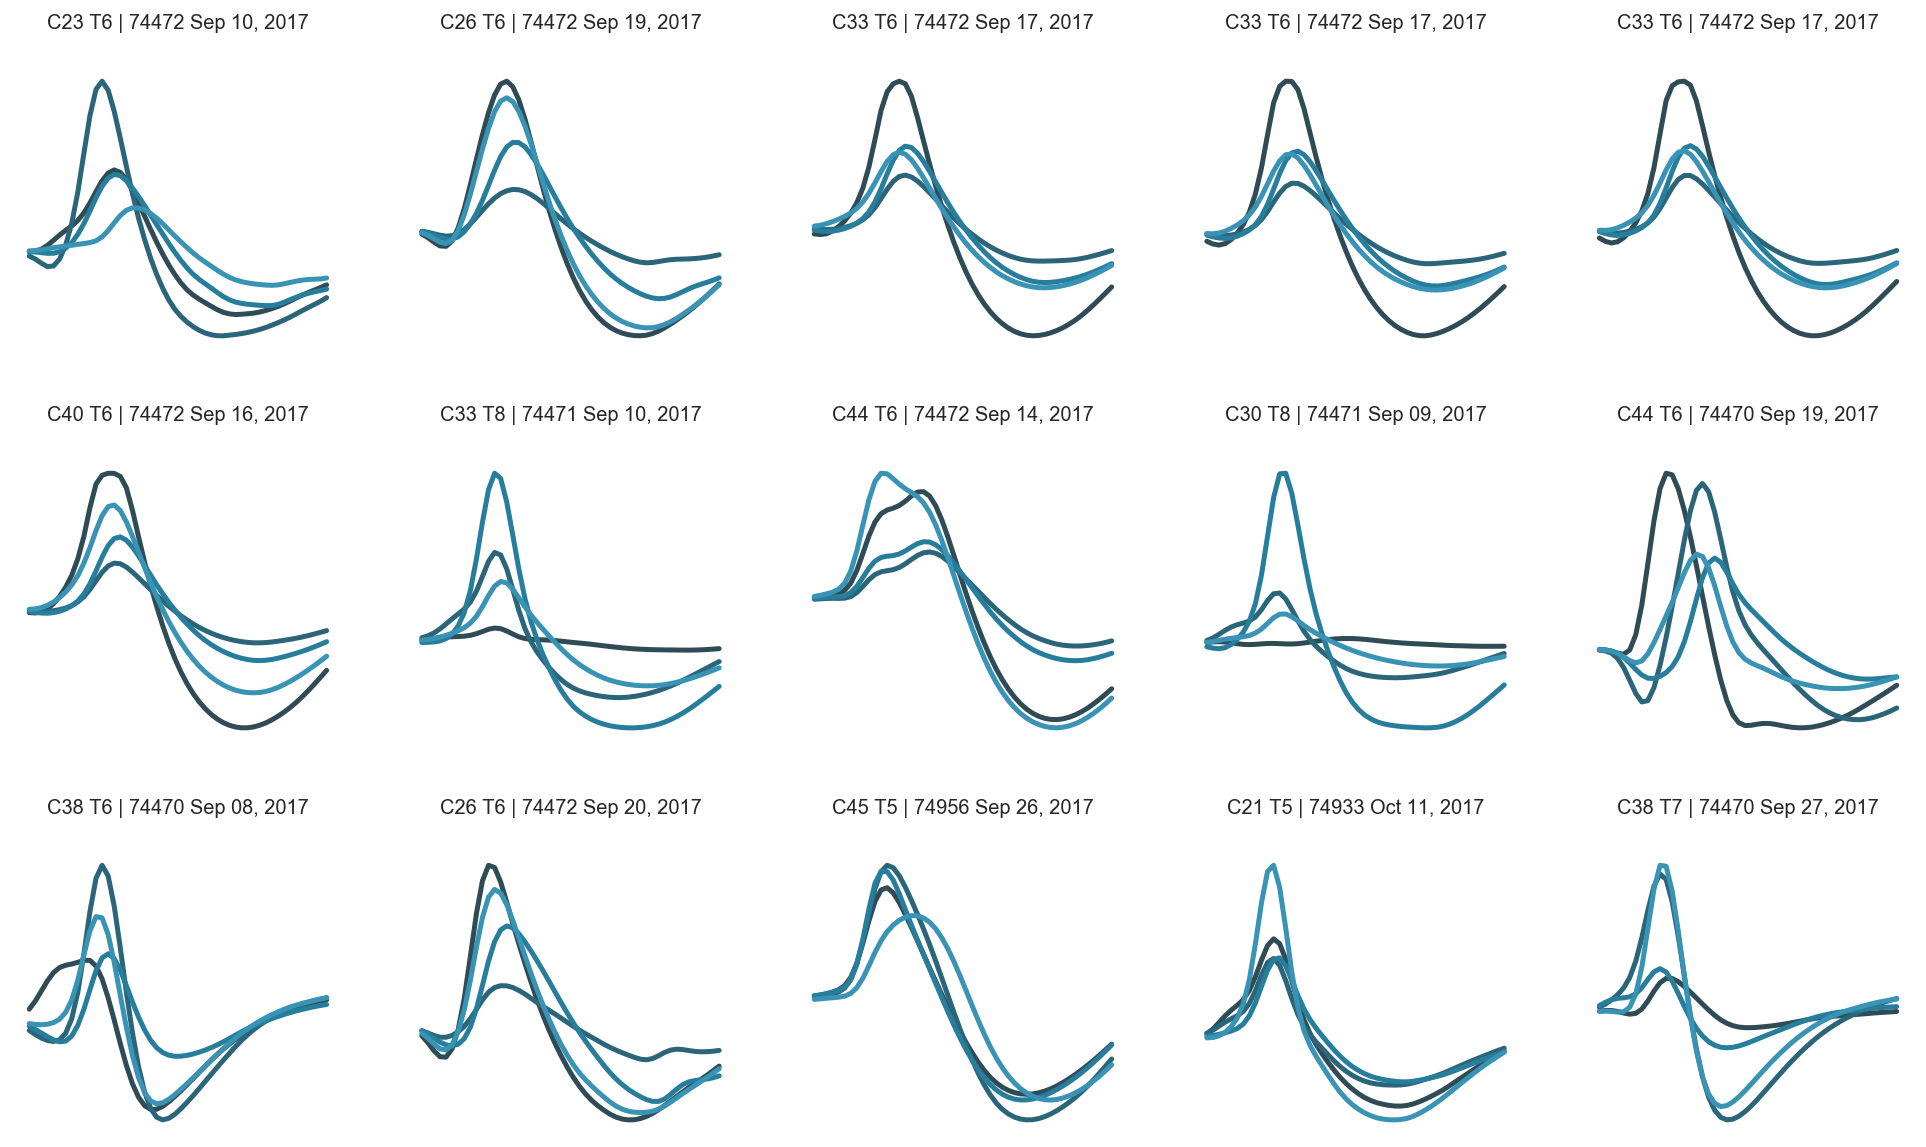

HBox(children=(IntProgress(value=0, max=15), HTML(value='')))


Generating plot ...


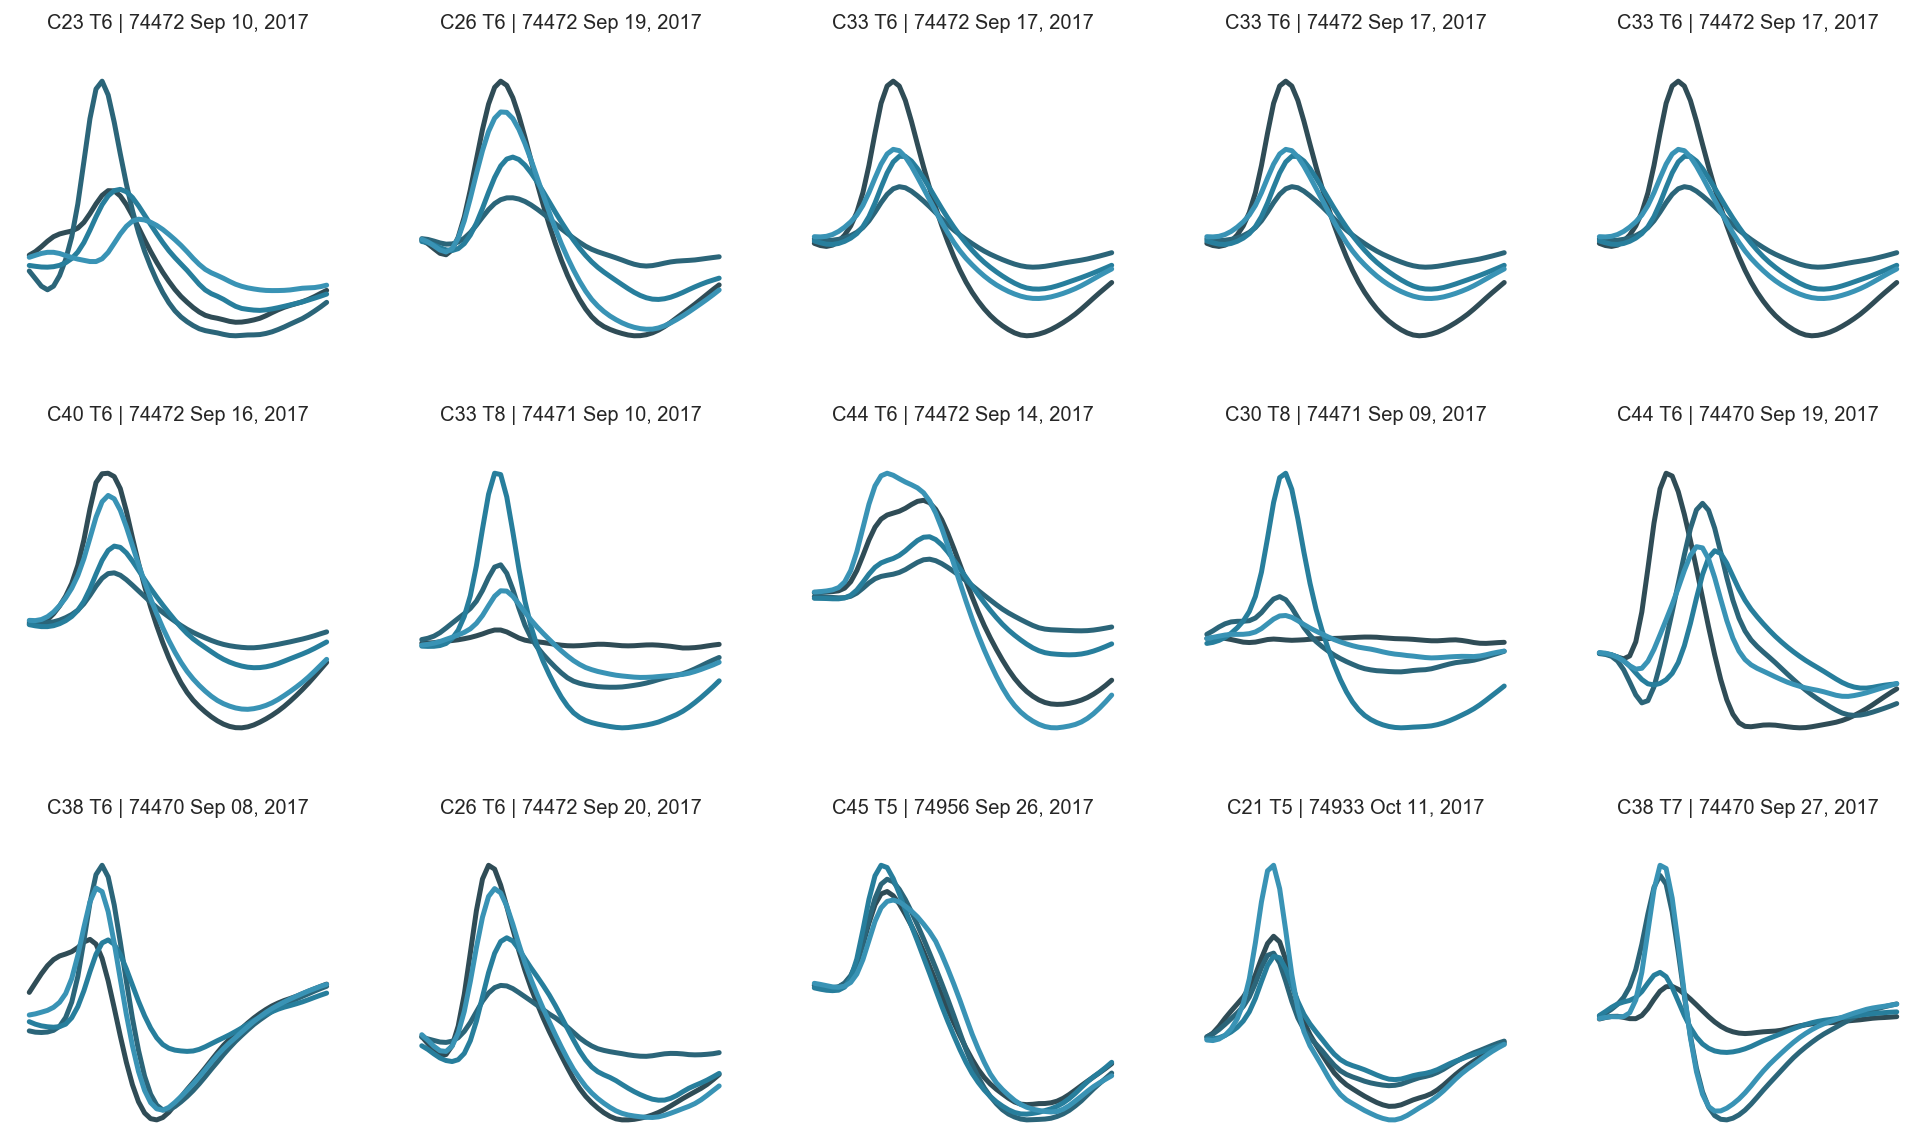

HBox(children=(IntProgress(value=0, max=15), HTML(value='')))


Generating plot...


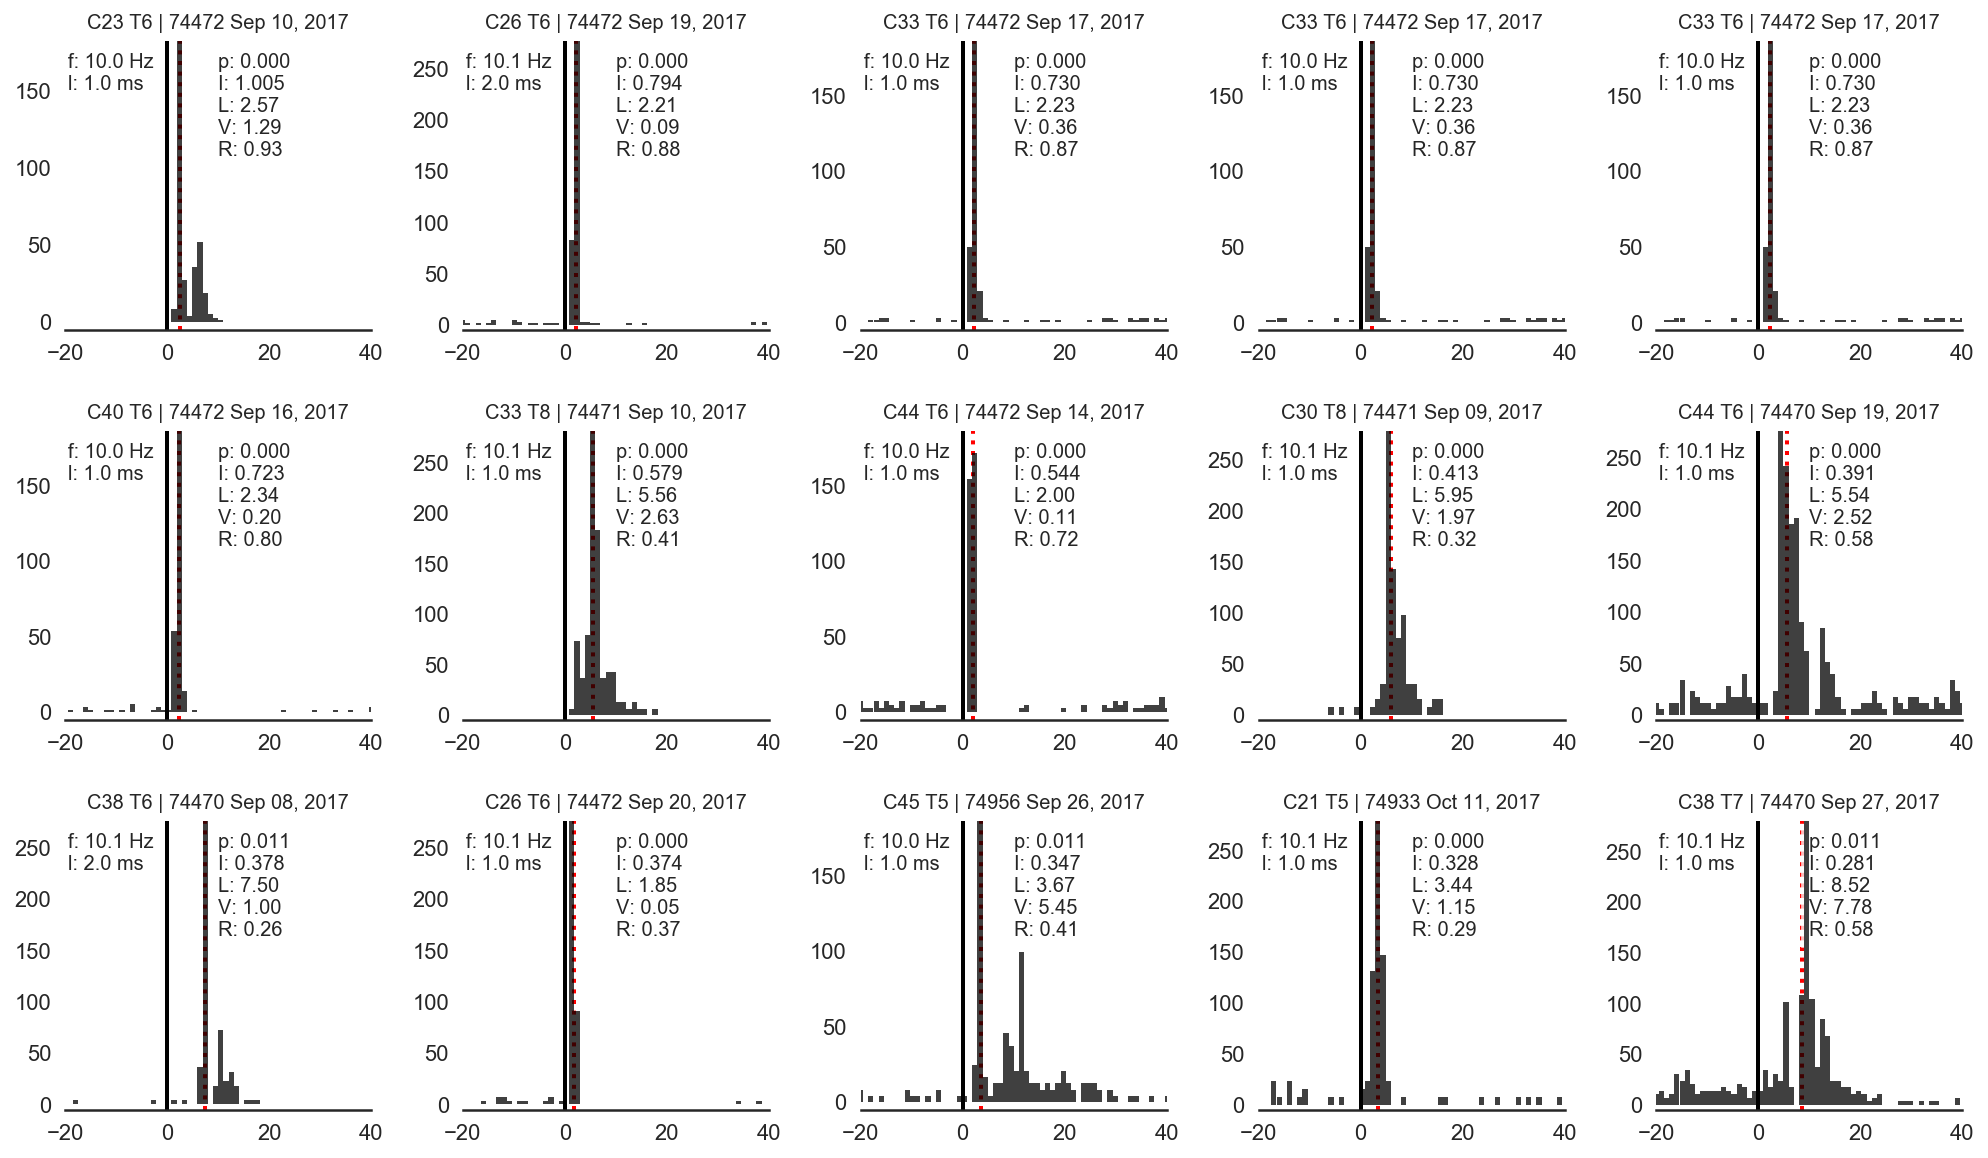

In [23]:
# Draw some examples of baseline and laser mean waveforms, and then PSTHs
draw_waveforms(excited_cells,'mean_wf',15,0)
draw_waveforms(excited_cells,'mean_wf_laser',15,0)
create_spike_plots_stimulus(excited_cells,15,0,False)

### To retrieve more data ... 

In [25]:
excited_cells.columns

Index(['n_drive_user', 'cluster_no', 'session_ts', 'animal_id', 'tetrode_no',
       'analysis_ts', 'filename', 'analysis_window', 'salt_window',
       'sample_rate', 'sample_rate_inp', 'ibi', 'stim_freq', 'stim_length',
       'counter_stimuli', 'excited', 'salt_p', 'salt_i', 'ex_latency_mean',
       'ex_latency_median', 'ex_latency_var', 'ex_latency_reliabil',
       'stats_p_inhib_10', 'stats_p_inhib_20', 'stats_p_inhib_30',
       'stats_p_inhib_40', 'inhibited', 'inhib_lowest_p',
       'inhib_lowest_p_interval', 'change_point_ms', 'no_sessions',
       'mean_wf_laser', 'spiketimes_cluster', 'stimulus_timepoints', 'sum_1ms',
       'bin_edges_1ms', 'binnumber_1ms', 'mean_wf', 'session_name',
       'isi_stats_contam_perc', 'pearson_r_wf'],
      dtype='object')

In [73]:
psql = psql_neuroballs(excited_cells) # initialize retrieval

Length of input dataframe: 47


In [74]:
psql.retrieve_data()

VBox(children=(HBox(children=(SelectMultiple(layout=Layout(align_items='stretch', display='flex', flex_flow='row', height='150px', width='200px'), options={'LFP': 'lfp_tb', 'Tracking': 'tracking_tb', 'Spiketimes + Tracking': 'spiketimes_tracking_tb', 'Theta Phase Tuning': 'phase_tuning_tb', 'Interspike interval stats': 'ISI_tb', 'Spiketime autocorr': 'st_autocorr_tb', 'HD tuning stats': 'hd_tuning_tb', 'Ratemaps (KLUSTA)': 'ratemaps_tb', 'Spatial autocorr': 'autocorr_gs_tb', 'Waveforms': 'waveforms_tb', 'Stimulus stats': 'stimulus_tb', 'Stimulus mats': 'stimulus_mat_tb', 'BNT all (NEW!)': 'BNT_tb_screen', 'Waveform stats': 'waveforms_stats_tb'}, value=()), SelectMultiple(layout=Layout(align_items='stretch', display='flex', flex_flow='row', height='150px', width='240px'), options=('Select a table to the left',), value=()), Textarea(value="NOT LIKE '%las%'", layout=Layout(align_items='stretch', display='flex', flex_flow='column', height='150px'), placeholder='Type filter for session_name'))), HBox(children=(Button(description='Print selection', layout=Layout(align_items='stretch', display='flex', flex_flow='column', height='15%', width='10%'), style=ButtonStyle(), tooltip='Click here to show which entries you marked for retrieval'), Button(description='Get cursor', layout=Layout(align_items='stretch', display='flex', flex_flow='column', height='15%', width='10%'), style=ButtonStyle(), tooltip='Click here to get a cursor instead of a dataset'), Button(button_style='info', description='Get ze data!', layout=Layout(align_items='stretch', display='flex', flex_flow='column', height='15%', width='10%'), style=ButtonStyle(), tooltip='Click here to retrieve data from the database')))), layout=Layout(align_items='stretch', border='', display='flex', flex_flow='columns', height='200px', width='100%'))

Retrieving data ... Dataframe not empty


HBox(children=(IntProgress(value=0, description='Mining tables: ', max=1), HTML(value='')))

bins_angle_center


HBox(children=(IntProgress(value=0, description='hd_tuning_tb: ', max=47), HTML(value='')))

Success. NaNs: 0



In [75]:
data = psql.data()

HBox(children=(IntProgress(value=0, max=15), HTML(value='')))


Generating plot ...


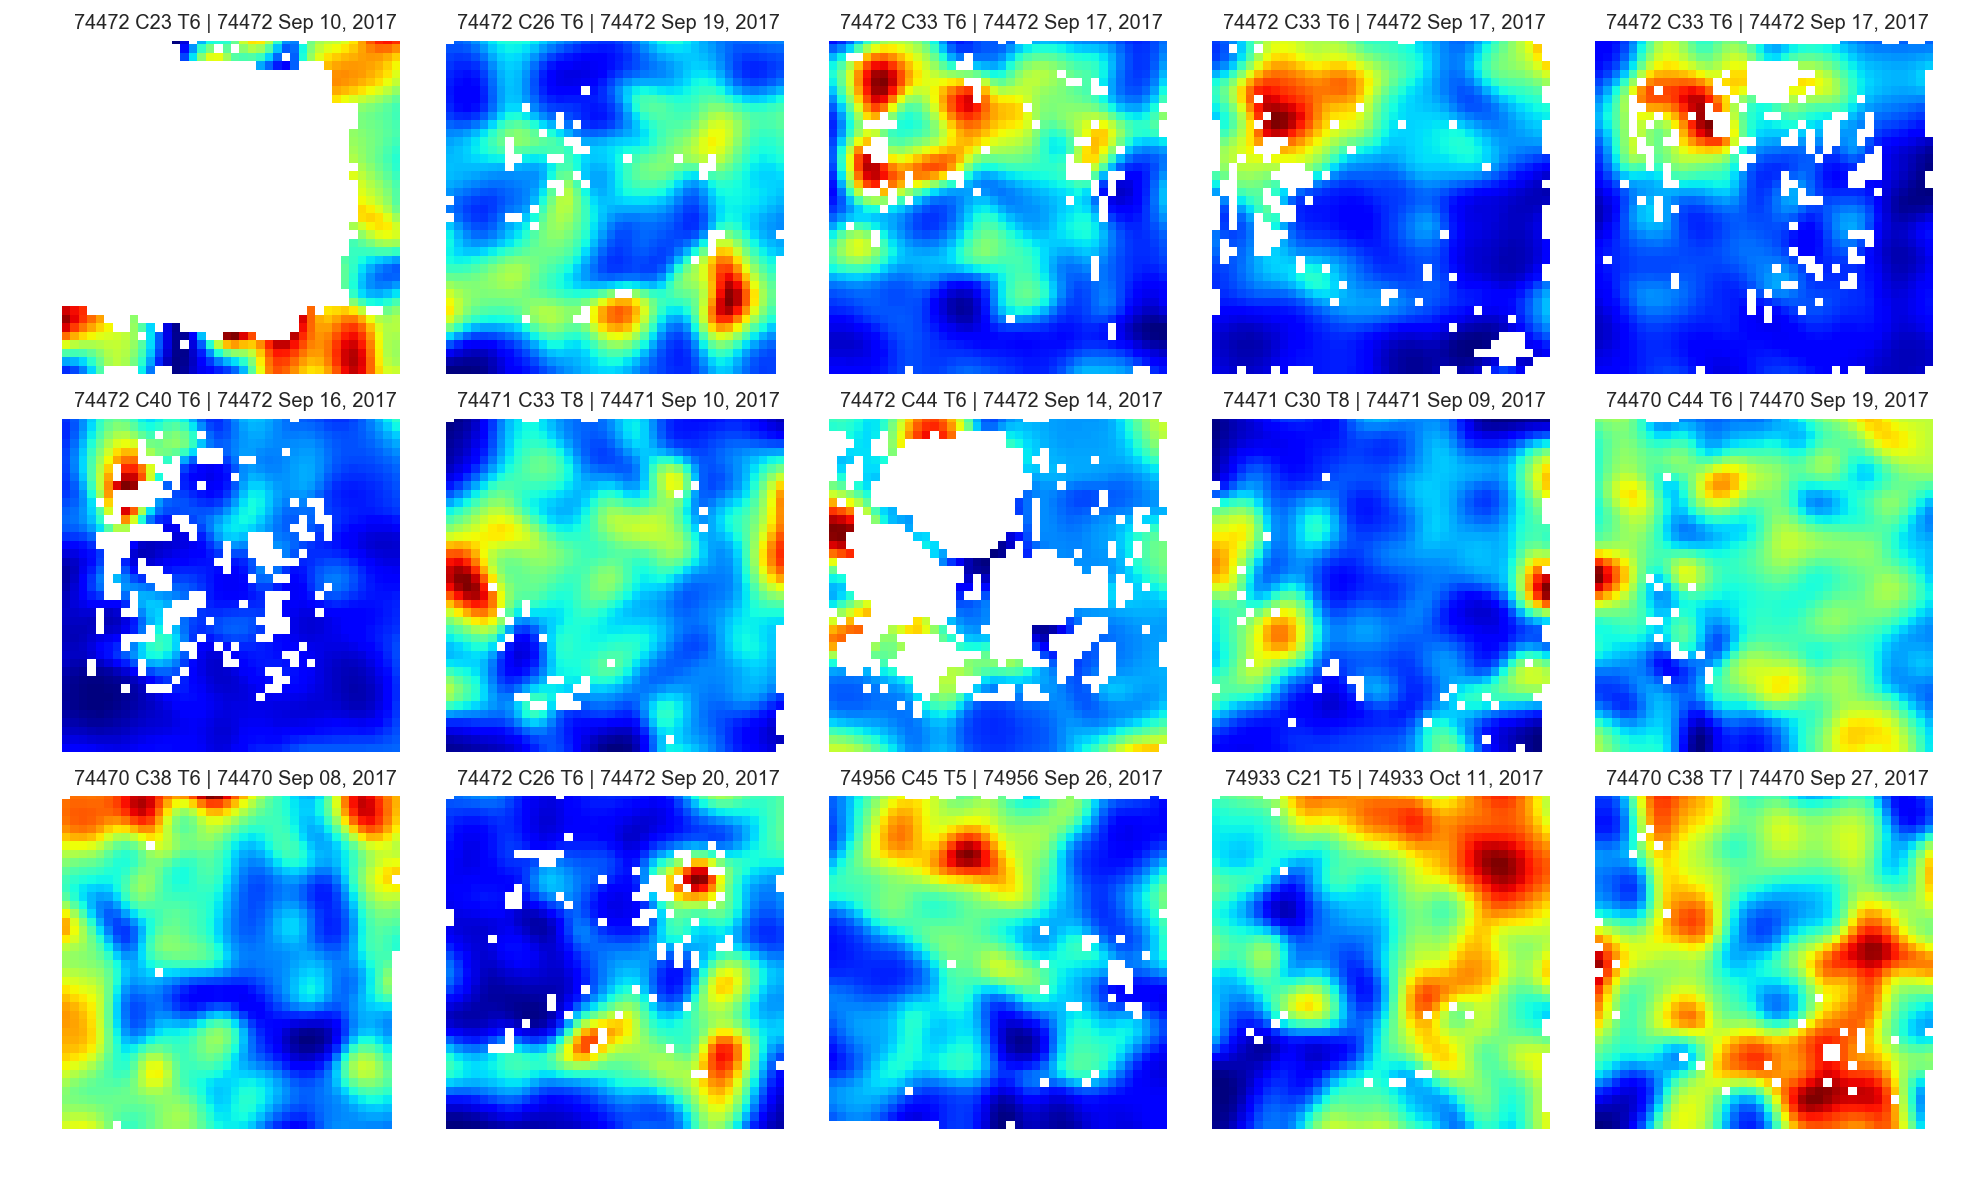

In [33]:
# for example ... 
draw_ratemaps(data,'masked_ratemap',15,0)

In [76]:
data.columns

Index(['n_drive_user', 'cluster_no', 'session_ts', 'animal_id', 'tetrode_no',
       'analysis_ts', 'filename', 'analysis_window', 'salt_window',
       'sample_rate', 'sample_rate_inp', 'ibi', 'stim_freq', 'stim_length',
       'counter_stimuli', 'excited', 'salt_p', 'salt_i', 'ex_latency_mean',
       'ex_latency_median', 'ex_latency_var', 'ex_latency_reliabil',
       'stats_p_inhib_10', 'stats_p_inhib_20', 'stats_p_inhib_30',
       'stats_p_inhib_40', 'inhibited', 'inhib_lowest_p',
       'inhib_lowest_p_interval', 'change_point_ms', 'no_sessions',
       'mean_wf_laser', 'spiketimes_cluster', 'stimulus_timepoints', 'sum_1ms',
       'bin_edges_1ms', 'binnumber_1ms', 'mean_wf', 'session_name',
       'isi_stats_contam_perc', 'pearson_r_wf', 'bins_angle_center',
       'hist_angle_smooth', 'tc_stats_mvl', 'tc_stats_mean', 'tc_stats_var'],
      dtype='object')

HBox(children=(IntProgress(value=0, max=15), HTML(value='')))


Generating plot ...


C:\Users\davidcr\AppData\Local\Continuum\Miniconda2\envs\ms\lib\site-packages\matplotlib\projections\polar.py:65: RuntimeWarning: invalid value encountered in less
  mask = r < 0


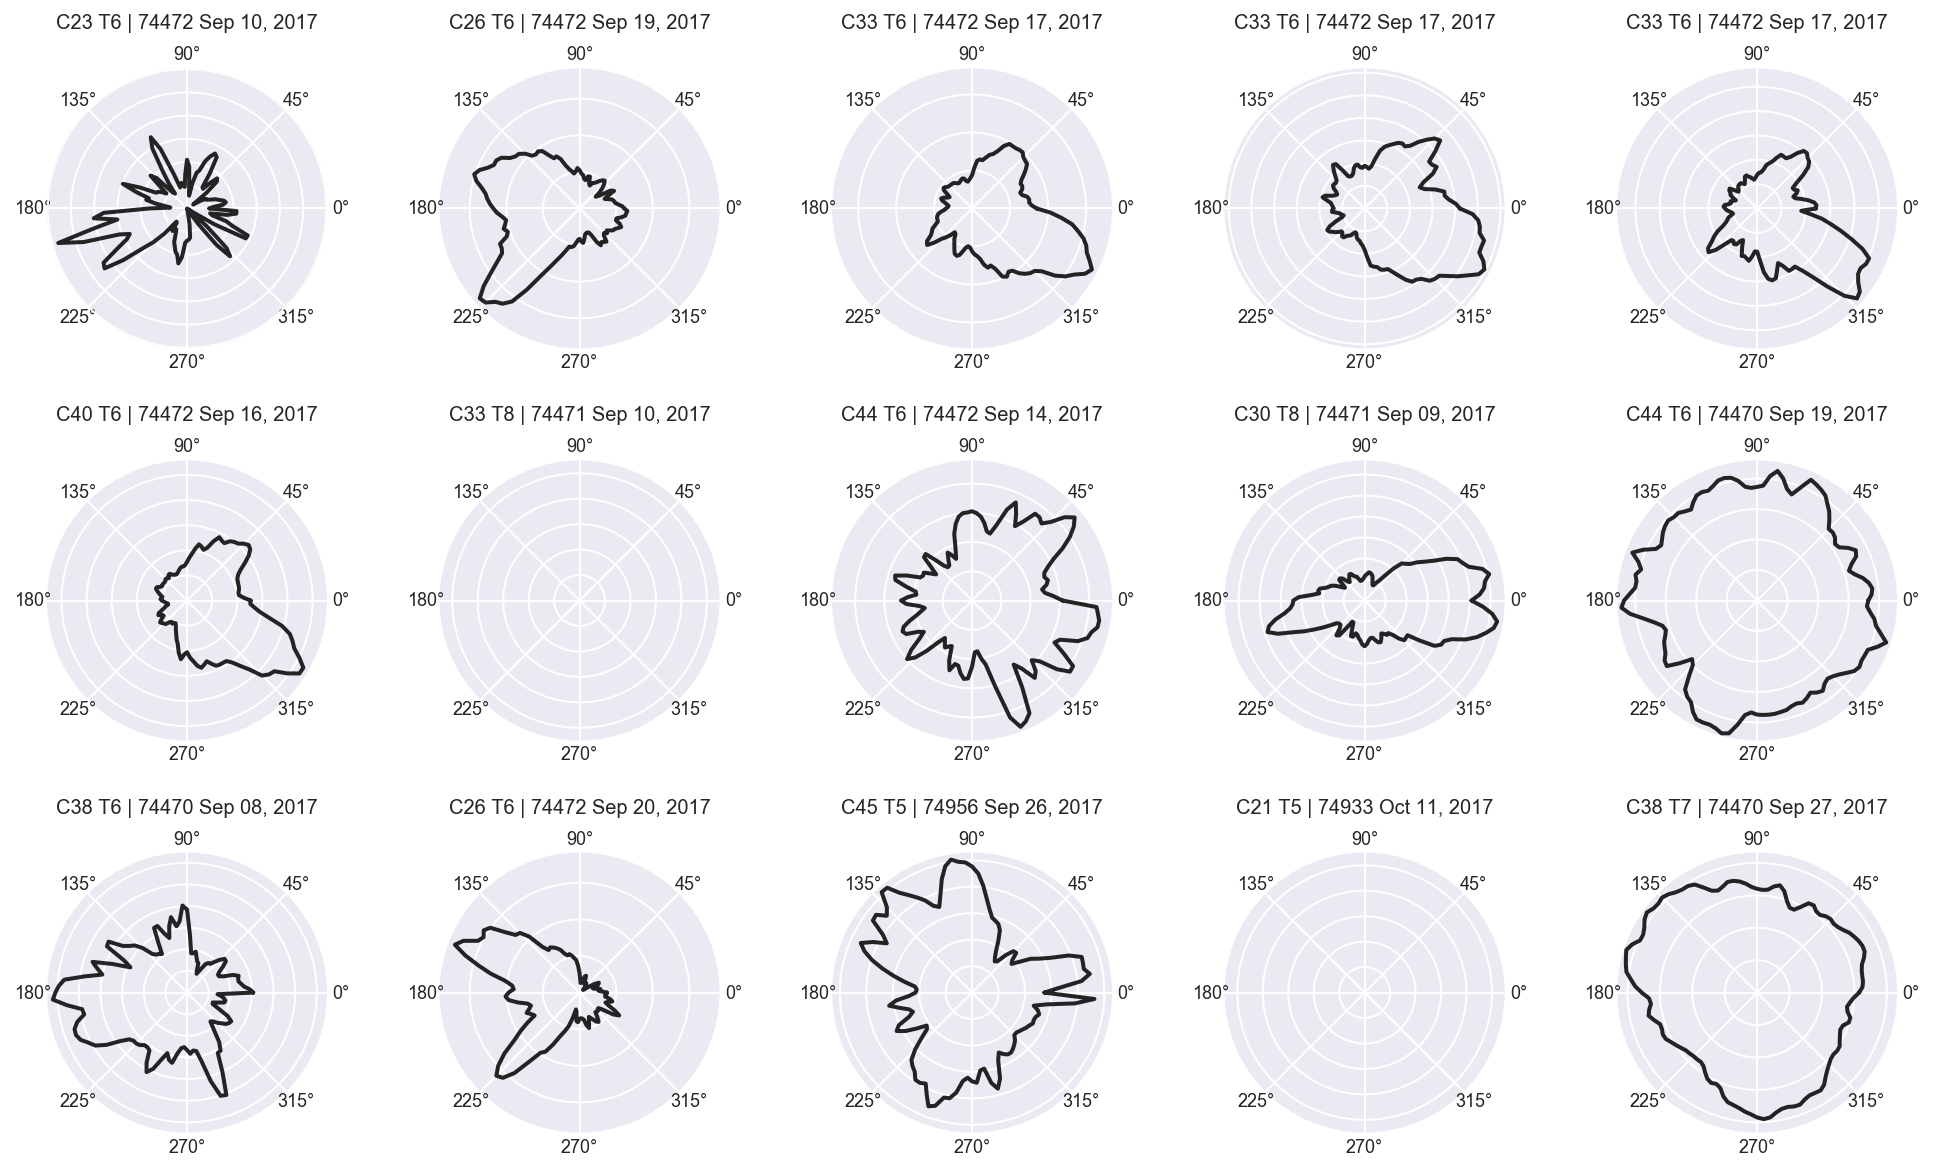

In [47]:
draw_tuning_curves(data, ['bins_angle_center_bnt','hist_angle_smooth_bnt'], 15, 0, 'E')

HBox(children=(IntProgress(value=0, max=15), HTML(value='')))


Generating plot ...


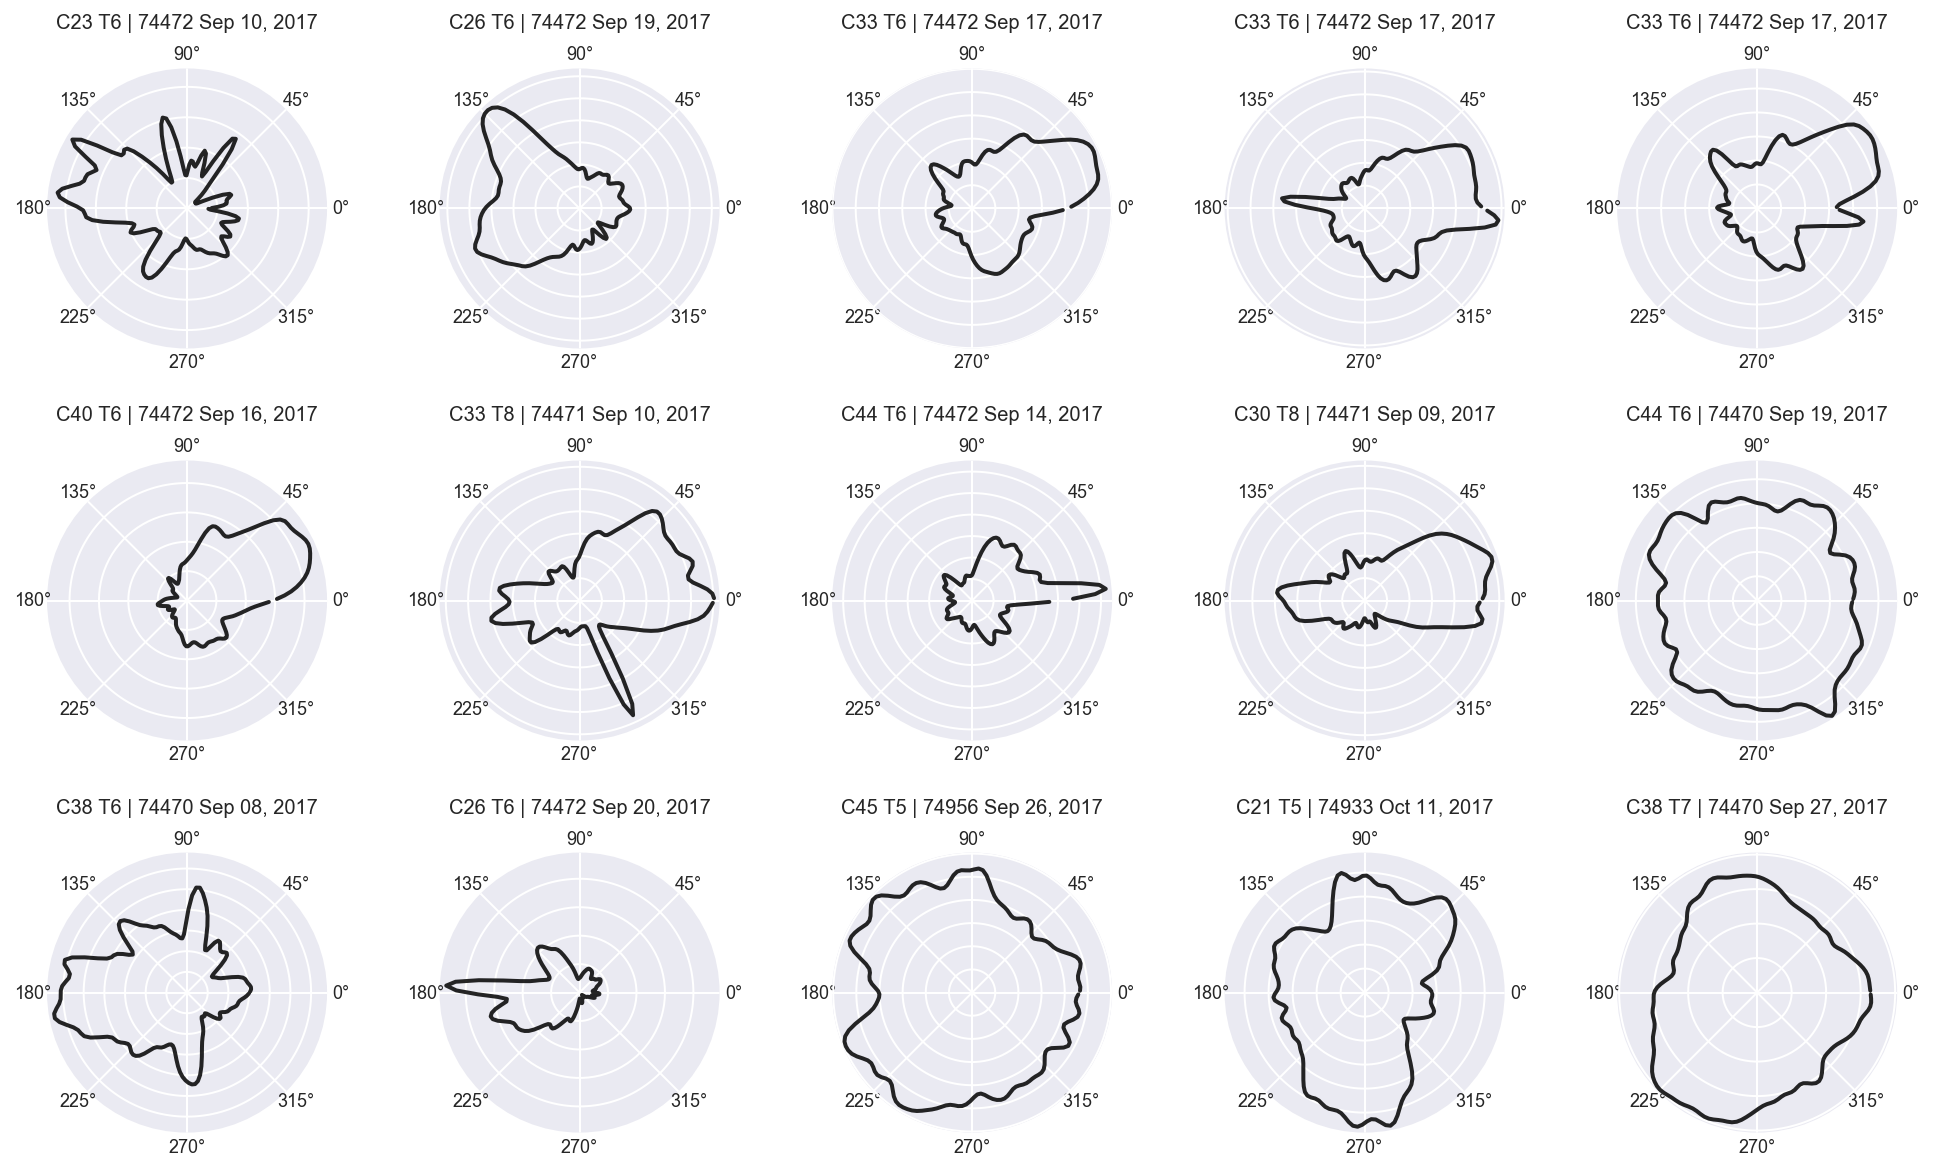

In [44]:
draw_tuning_curves(data, ['bins_angle_center','hist_angle_smooth'], 15, 0, 'E')

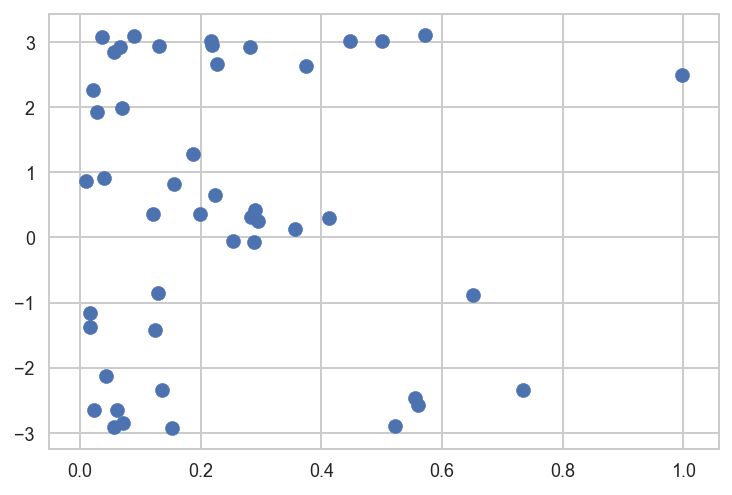

In [80]:
plt.scatter(data['tc_stats_mvl'],data['tc_stats_mean'])

ValueError: object too deep for desired array

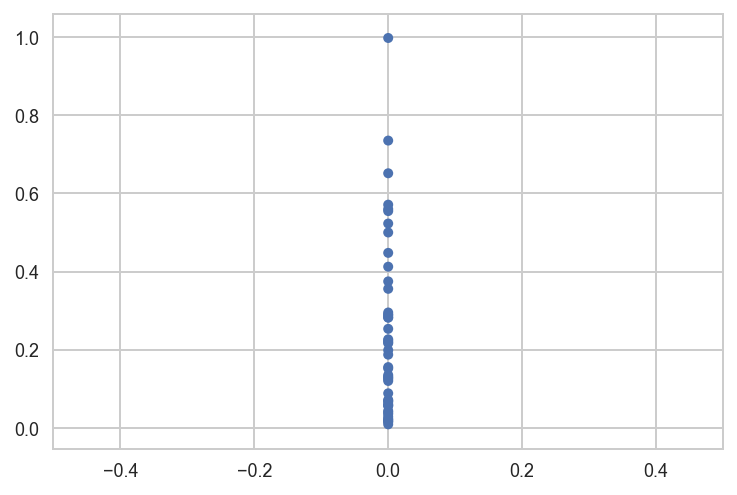

In [86]:
import seaborn as sns
sns.set_style("whitegrid")

ax = sns.swarmplot(y="tc_stats_mvl", data = data)

In [67]:
np.mean(data['ex_latency_mean'])

4.3578809677883399